# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
from string import digits
import re 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding,Input,RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
lines= pd.read_table('deu.txt', names=['eng', 'deu'])

In [5]:
lines.shape

(195847, 2)

In [6]:
lines.head()

,eng,deu
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Wow!,Potzdonner!
4,Wow!,Donnerwetter!


In [0]:
lines = lines[:50000]

In [0]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.deu=lines.deu.apply(lambda x: x.lower())

In [0]:
# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("'", '', x))

In [0]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.deu=lines.deu.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.deu=lines.deu.apply(lambda x: x.translate(remove_digits))

In [0]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.deu=lines.deu.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.deu=lines.deu.apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences. I am not German so , I am doing so for my ease
lines.deu = lines.deu.apply(lambda x : 'START_ '+ x + ' _END')

In [14]:
lines.sample(10)

,eng,deu
37196,the party was a flop,START_ die party war ein reinfall _END
21275,tom loves sunsets,START_ tom liebt sonnenuntergänge _END
1349,let me see,START_ lass mich sehen _END
47147,he was voted prom king,START_ er wurde zum ballkönig gewählt _END
13204,did you know him,START_ kanntest du ihn _END
3871,tom has left,START_ tom ist schon gegangen _END
24770,it is cloudy today,START_ es ist heute wolkig _END
19199,im half japanese,START_ ich bin zur hälfte japaner _END
47263,how about another beer,START_ wie wär’s mit noch einem bier _END
2895,come forward,START_ tretet vor _END


In [0]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
# Vocabulary of German 
all_german_words=set()
for ger in lines.deu:
    for word in ger.split():
        if word not in all_german_words:
            all_german_words.add(word)

In [16]:
# Max Length of source sequence
import numpy as np
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

7

In [17]:
# Max Length of target sequence
lenght_list=[]
for l in lines.deu:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

19

In [18]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_german_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_german_words)
num_encoder_tokens, num_decoder_tokens

(6278, 10611)

In [19]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

10612

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [22]:
lines = shuffle(lines)
lines.head(10)

,eng,deu
14628,is tom at school,START_ ist tom in der schule _END
32136,tom isnt listening,START_ tom hört nicht zu _END
8197,tom gave blood,START_ tom hat mit blut bezahlt _END
2168,is it toms,START_ ist es toms _END
9686,green suits you,START_ grün steht euch _END
39654,youve put on weight,START_ ihr habt zugenommen _END
31811,tom disappointed me,START_ tom hat mich enttäuscht _END
40393,every dog has his day,START_ auch ein blindes huhn findet mal ein korn _END
6363,are you two ok,START_ seid ihr beide in ordnung _END
45097,we must work together,START_ wir müssen zusammenarbeiten _END


In [23]:
# Train - Test Split
X, y = lines.eng, lines.deu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((45000,), (5000,))

**Save the train and test dataframes for reproducing the results later, as they are shuffled**

In [0]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Encoder - Decoder Model Architecture

In [0]:
latent_dim = 50

In [27]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

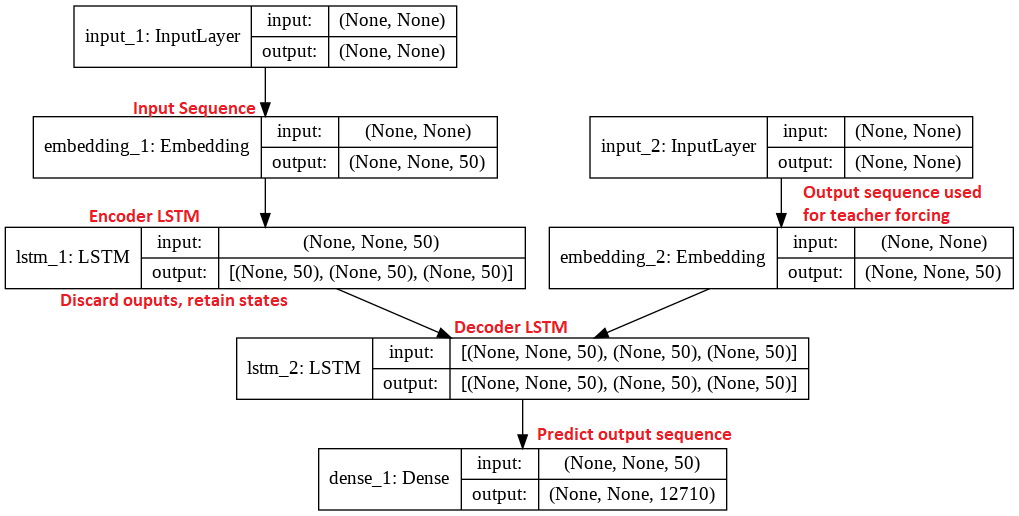

In [30]:
from IPython.display import Image
Image(retina=True, filename='train.png')

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 15

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     308000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     515850      input_2[0][0]                    
____________________________________________________________________________________________

In [32]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


Epoch 1/15
351/351 [==============================] - 63s 181ms/step - loss: 5.7252 - acc: 0.2032 - val_loss: 5.0113 - val_acc: 0.2523
Epoch 2/15
351/351 [==============================] - 60s 172ms/step - loss: 4.6953 - acc: 0.2958 - val_loss: 4.4856 - val_acc: 0.3378
Epoch 3/15
351/351 [==============================] - 60s 172ms/step - loss: 4.2966 - acc: 0.3530 - val_loss: 4.1928 - val_acc: 0.3729
Epoch 4/15
351/351 [==============================] - 61s 172ms/step - loss: 4.0338 - acc: 0.3844 - val_loss: 3.9865 - val_acc: 0.3997
Epoch 5/15
351/351 [==============================] - 61s 172ms/step - loss: 3.8394 - acc: 0.4095 - val_loss: 3.8372 - val_acc: 0.4207
Epoch 6/15
351/351 [==============================] - 61s 173ms/step - loss: 3.6829 - acc: 0.4310 - val_loss: 3.6950 - val_acc: 0.4399
Epoch 7/15
351/351 [==============================] - 61s 174ms/step - loss: 3.5468 - acc: 0.4482 - val_loss: 3.5794 - val_acc: 0.4556
Epoch 8/15
351/351 [==============================] - 

In [0]:
# save model
model.save_weights('translate.h5')

In [0]:
model.load_weights('translate.h5')

# Inference Setup

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Decode sample sequeces

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Evaluation on Train Dataset

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [40]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual German Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted German Translation:', decoded_sentence[:-4])

Input English sentence: how may i help you
Actual German Translation:  wie darf ich dir helfen 
Predicted German Translation:  wie kann ich dich 
